In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats

In [2]:
# Load datasets
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc") # GRACE data

Text(0, 0.5, 'Surface load (mm water equiv.)')

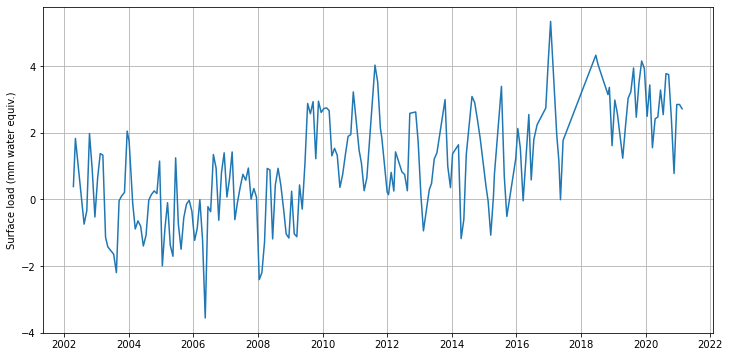

In [3]:
# surface mass load for seattle

seattle = ds.isel(lat=47, lon=-122)
plt.subplots(figsize=(12,6))
plt.plot(seattle.time,seattle.lwe_thickness)
plt.grid()
plt.ylabel('Surface load (mm water equiv.)')

In [4]:
number_of_time_steps = len(ds.time)
data_matrix = np.zeros((360*720,number_of_time_steps))

for i in range(number_of_time_steps):
    this_data = ds.isel(time=i).lwe_thickness
#     print(this_data.values.flatten().shape)
    data_matrix[:,i] = this_data.values.flatten()
    
#     fig,ax = plt.subplots(figsize=(12,12))
#     globe_2010.plot(vmin=-10,vmax=10)


In [5]:
# After analyzing the PC's as we calculated them, next try the same analysis again with the trend removed.
# data_matrix has dimensions rows-x-cols <--> space-x-time
# we want to detrend in TIME, so we want to remove the trend form the second axis (columns) of data_matrix 
# (see arguments for scipy.signal.detrend)

## Singular Value Decomposition

The Singular Value Decomposition writes a matrix D as:

D = U * S * V

In [6]:
from scipy.sparse.linalg import svds

u,s,v = svds(data_matrix,k=7)
print(s)

[  6618.979566     7246.31299665  12092.53326692  12810.95678694
  16579.71881291  22979.22477239 161493.29184373]


In [7]:
u.shape

(259200, 7)

In [8]:
s.shape

(7,)

In [9]:
v.shape

(7, 194)

In [10]:
which_mode = 6

first_left_singular_vector = np.reshape(u[:,which_mode],this_data.values.shape)
first_right_singular_vector = v[which_mode,:]
print(first_left_singular_vector.shape)
print(first_right_singular_vector.shape)

(360, 720)
(194,)


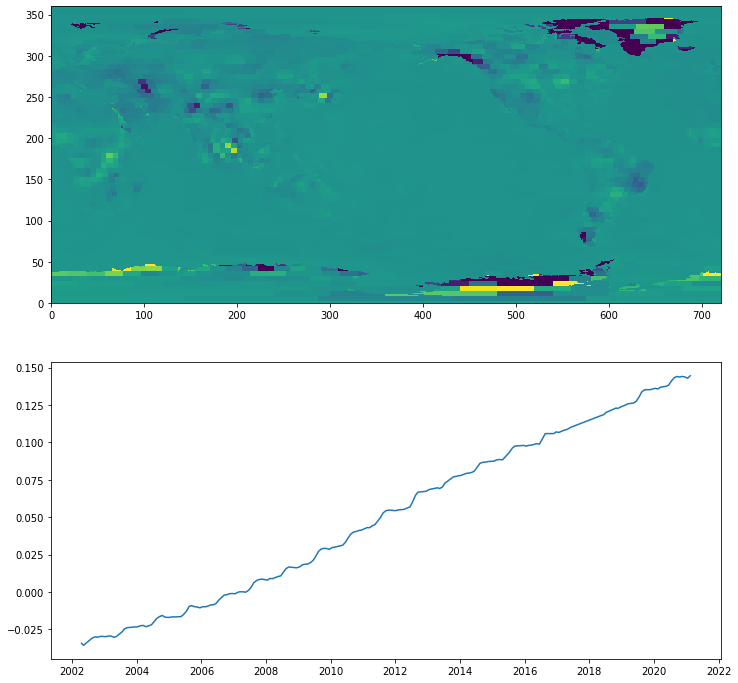

In [11]:
plt.subplots(2,1,figsize=(12,12))
plt.subplot(2,1,1)
plt.pcolor(first_left_singular_vector,vmin=-0.005,vmax=0.005)
plt.subplot(2,1,2)
plt.plot(ds.time,first_right_singular_vector)

<BarContainer object of 7 artists>

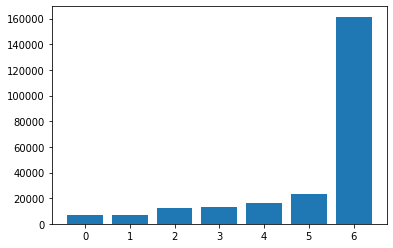

In [12]:
plt.bar(range(len(s)),s)

In [13]:
s[6]/sum(s)

0.6733909027650883

## Calculation of the surface mass load at a given point in space and time

D = U * S * V, so to approximate D using the first mode, you would use

D = U[:,6]*S[6]@V[6,:]

Then every column will need to be np.reshaped()'d to the right size to make a map

In [14]:
type(data_matrix)
print(u[:,6].shape)
print(s[6].shape)
print(v[6,:].shape)

(259200,)
()
(194,)


## D = Reconstruction of the data using only first PC

In [15]:
# Function for reconstruction of data

def D_reconstruct(which_PC):
    D_reconstruct = u[:,which_PC].reshape(259200,1)*s[which_PC]@v[which_PC,:].reshape(1,194)
    return D_reconstruct

In [17]:
# Finds index of closest time to some input time
time_index = np.argmin(np.abs(ds.time.values - np.datetime64('2010-01-01')))
this_latitude = 47
this_longitude = -122

# Finds index of closest latitude to some input latitude
lat_index = np.argmin(np.abs(ds.lat.values - this_latitude))

# Finds index of closest longitude to some input longitude
lon_index = np.argmin(np.abs(ds.lon.values - this_longitude))

nlong = len(ds.lon)
pos_index = (lat_index -1) * nlong + lon_index

# (D is calculated using D_reconstruct())
# D[pos_index, time_index] 

<ipython-input-18-a88fc7387db7>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = plt.pcolor(ds.lon.values,ds.lat.values, data_reconstruction,vmin=-10,vmax=10, cmap = 'seismic')


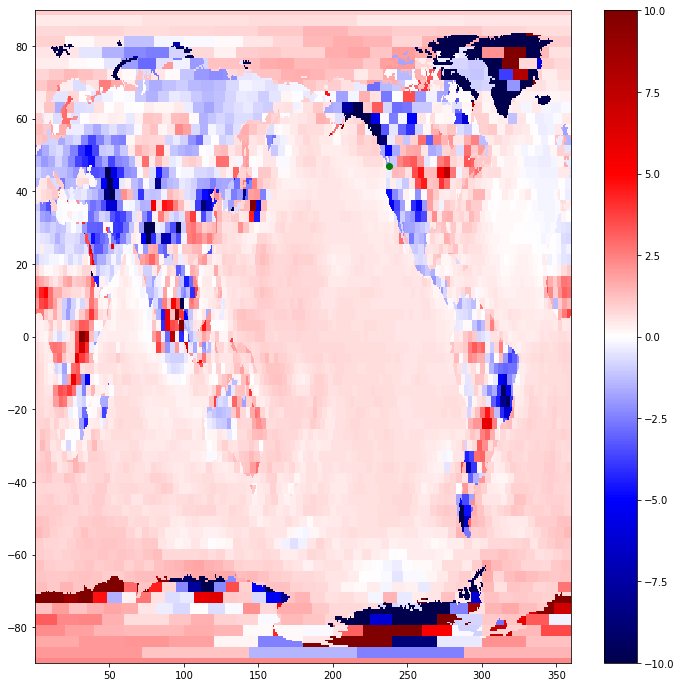

In [18]:
data_reconstruction = first_left_singular_vector * s[6] * v[6, time_index]

plt.subplots(figsize=(12,12))
c = plt.pcolor(ds.lon.values,ds.lat.values, data_reconstruction,vmin=-10,vmax=10, cmap = 'seismic')
plt.plot(this_longitude + 360, this_latitude,'og')
plt.colorbar(c)

In [20]:
## open eq catalog, pull out lat long time and find D at that point

catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

# # Finds index of closest time to some input time
# time_index = np.argmin(np.abs(ds.time.values - np.datetime64('2010-01-01')))
# this_latitude = 47
# this_longitude = -122

# # Finds index of closest latitude to some input latitude
# lat_index = np.argmin(np.abs(ds.lat.values - this_latitude))

# # Finds index of closest longitude to some input longitude
# lon_index = np.argmin(np.abs(ds.lon.values - this_longitude))

# nlong = len(ds.lon)
# pos_index = (lat_index -1) * nlong + lon_index

# D[pos_index, time_index]

In [21]:
type(catalog)

pandas.core.frame.DataFrame

In [23]:
catalog_array = catalog.to_numpy()

eq_lat = catalog_array[:,1]
eq_lon = catalog_array[:,2]
eq_time = catalog_array[:,3]
total = len(catalog)
D_eq_values = np.zeros(total)

## D = Reconstruction of the data using PCs

In [24]:
def D_reconstruct(which_PC):
    D_reconstruct = u[:,which_PC].reshape(259200,1)*s[which_PC]@v[which_PC,:].reshape(1,194)
    return D_reconstruct

In [25]:
n = 7
D_values = np.zeros((6,7))

for i in range(1,n):
    exec(f'D_{i} = D_reconstruct(n - i)')

In [30]:
# D_1 is the reconstructed surface load data using first PC = D_reconstruct(6)
# D_2 is the reconstructed surface load data using second PC = D_reconstruct(5)

In [31]:
# Function to calculate a specific D value for time of earthquake

def calculate_D_eq(eq_time, eq_lat, eq_lon, which_D):
    time_index = np.argmin(np.abs(ds.time.values - np.datetime64(eq_time)))
    lat_index = np.argmin(np.abs(ds.lat.values - eq_lat))
    lon_index = np.argmin(np.abs(ds.lon.values - eq_lon))
    nlong = len(ds.lon)
    pos_index = (lat_index -1) * nlong + lon_index
    return which_D[pos_index, time_index]

# Function to calculate a D values value at times of earthquake occurence using 
# (specify using which primary component)

def calculate_D_eq_values(which_D):
    for i in range(total):
        D_eq_value = calculate_D_eq(eq_time[i], eq_lat[i], eq_lon[i], which_D)
        D_eq_values[i] = D_eq_value
    return D_eq_values

In [33]:
calculate_D_eq_values(D_1)

array([ 4.25953655,  4.25953655,  4.25953655, ..., -0.89574501,
       -0.21415966, -0.29122169])

In [35]:
# not sure how to create a fn for this

D_eq_1 = calculate_D_eq_values(D_1)
D_eq_2 = calculate_D_eq_values(D_2)
D_eq_3 = calculate_D_eq_values(D_3)
D_eq_4 = calculate_D_eq_values(D_4)
D_eq_5 = calculate_D_eq_values(D_5)
D_eq_6 = calculate_D_eq_values(D_6)

In [39]:
# saving reconstructed D values to csv files
    
np.savetxt('D_1.csv', D_1, delimiter=',')
np.savetxt('D_2.csv', D_2, delimiter=',')
np.savetxt('D_3.csv', D_3, delimiter=',')
np.savetxt('D_4.csv', D_4, delimiter=',')
np.savetxt('D_5.csv', D_5, delimiter=',')
np.savetxt('D_6.csv', D_6, delimiter=',')

In [40]:
# saving D values for times of earthquake occurence to csv file

np.savetxt('D_eq_1.csv', D_eq_1, delimiter=',')
np.savetxt('D_eq_2.csv', D_eq_2, delimiter=',')
np.savetxt('D_eq_3.csv', D_eq_3, delimiter=',')
np.savetxt('D_eq_4.csv', D_eq_4, delimiter=',')
np.savetxt('D_eq_5.csv', D_eq_5, delimiter=',')
np.savetxt('D_eq_6.csv', D_eq_6, delimiter=',')


# push csv to github 

In [ ]:
# First step for this notebook:  plot the second PC spatial pattern